<a href="https://colab.research.google.com/github/pulkitgopalani/villani_sgd/blob/main/Regression_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl


import seaborn as sb
# sb.set_context("paper")

import math

dtype = torch.float64 # tensor type

In [ ]:
def sin_data(n, d=20):
    # returns n noisy samples (x,y) of sin function
    # y = sin(pi . ||x||^2)
    rng = np.random.default_rng(seed=42)
    x = rng.random(size=(n,d))
    y = np.sin((np.pi / d) * np.linalg.norm(x, axis=1) ** 2)

    return x, y

In [ ]:
def train_neuralnet(X, Y, c_reg, batch_size=16, lr=1e-2, m=80, d=20, test_frac=0.2, T=50000):
    '''
        This function runs a simple one layer neural network on the training set (X,Y) where X and Y are vectors of n samples
        m is the number of hidden units, T is the number of iterations
        returns the predictors for X
    '''

    train_loss_reg = []
    train_loss_unreg = []
    test_loss_unreg = []
    W_evolution = []

    rng = np.random.default_rng(seed=42)
    Bx = np.sqrt(d)

    W = torch.tensor(rng.normal(0.0, 1.0, (m, X.shape[1])) / np.sqrt(m), requires_grad = True).to('cuda')
    # weights of the first layer a m x dim matrix whose each entry ~ 1/sqrt{m}*N(0,1)
    a = torch.tensor(rng.normal(0.0, 1.0, (1, m)) / np.sqrt(m), requires_grad = False).to('cuda')
    # weights of the second layer ~ (1/sqrt{m})*N(0,1)
    a = torch.div(a, torch.linalg.vector_norm(a) * Bx)
    # Normalize a s.t. ||a|| = 1/Bx

    stepsize = lr

    W0 = W.data
    # print(f"W at start: {W0}")

    # test_frac is the fraction of data that is used as test data
    X_te, Y_te = X[:int(X.shape[0]*test_frac)], Y[:int(X.shape[0]*test_frac)]
    X_tr, Y_tr = X[int(X.shape[0]*test_frac):], Y[int(X.shape[0]*test_frac):]
    print(f"Train samples: {X_tr.shape[0]}, Test samples: {X_te.shape[0]}")

    dataloader = torch.utils.data.DataLoader(
        torch.cat((X_tr,Y_tr), dim=1),      # n x (d+1) tensor
        batch_size=batch_size,
        shuffle=True
    )

    for i in range(T):
      for idx, batch in enumerate(dataloader):
        # batch_x is B x d
        batch_x = batch[:, :-1]
        # batch_y is B x 1
        batch_y = batch[:, -1].reshape(-1, 1)

        train_output = torch.sigmoid(F.linear(input=batch_x, weight=W)).mm(a.t())

        loss = torch.mean((train_output-batch_y)**2) + (c_reg / 2) * torch.linalg.matrix_norm(W) ** 2

        # running gradient descent
        W.data = W.data - stepsize * grad(loss, W)[0]

      epoch_train_pred = torch.sigmoid(F.linear(input=X_tr, weight=W)).mm(a.t())
      epoch_test_pred = torch.sigmoid(F.linear(input=X_te, weight=W)).mm(a.t())
      epoch_train_loss = (torch.mean((epoch_train_pred - Y_tr) ** 2) + (c_reg / 2) * torch.linalg.matrix_norm(W) ** 2).float().item()

      if i % 1000 == 0 or i == T-1:
        print(f"Epoch {i} -------- \nReg. train loss: {epoch_train_loss}")
        print(f"Unreg. train loss: {torch.mean((epoch_train_pred - Y_tr) ** 2).item()}")
        print(f"Test loss: {torch.mean((epoch_test_pred - Y_te) ** 2).item()}\n")


      train_loss_reg.append(epoch_train_loss)
      train_loss_unreg.append(torch.mean((epoch_train_pred - Y_tr) ** 2).item())
      # (Unregularized) Loss on noisy train data
      test_loss_unreg.append(torch.mean((epoch_test_pred - Y_te) ** 2).item())
      # Loss on clean test data
      W_evolution.append(torch.linalg.matrix_norm(W-W0).item())

    del W, a
    return train_loss_reg, train_loss_unreg, test_loss_unreg, W_evolution

In [ ]:
def run_experiment(n, m, T, lr, c_r, d, test_frac, batch_size=16, input_generator = sin_data):
    '''
        Generates inputs using the input generator and train a neural network to
        estimate the input. m is the number of hidden units, T is the number of
        iterations, n is the number of samples.
        Note: x, y = input_generator(n) where input_generator returns n input
        samples x, y where x is an indepedent RV, and y is the dependent one.
    '''
    rng = np.random.default_rng(seed=42)
    By = 0.3

    print(f"Using c_reg = {c_r}, m={m}, stepsize={lr}\n")
    # print(f"Using m = {m}, stepsize = {lr}\n")
    x, y = input_generator(n, d)

    # generating tensors for the automatic differentation
    X = torch.tensor(x.reshape(len(x),-1)).type(dtype).to('cuda')
    Y = torch.tensor(y.reshape(len(y),-1)).type(dtype).to('cuda')


    # colors = ['blue', 'orange', 'green', 'red']

    sb.color_palette("viridis", as_cmap=True)

    train_losses = []
    test_losses = []
    W_evolutions = []

    for idx, noise_frac in enumerate([0.0, 0.5, 0.9]):
      print(f"Noise fraction: {noise_frac}")

      Y_te, Y_tr = Y[:int(X.shape[0]*test_frac)], Y[int(X.shape[0]*test_frac):]
      noise_mask = torch.from_numpy(rng.choice([0.0, 1.0], size=Y_tr.shape, p=[1-noise_frac, noise_frac])).to('cuda')
      #   Y_tr_noise = Y_tr + noise_mask * torch.from_numpy(By * (-1 + 2 * rng.random(size=Y_tr.shape))).to('cuda')
      Y_tr_noise = Y_tr + noise_mask * torch.from_numpy(0.05 * rng.standard_cauchy(size=Y_tr.shape)).to('cuda')

      Y_noise = torch.cat((Y_te, Y_tr_noise))
      # Y_noise has clean test data and noisy training data

      train_loss_reg, train_loss_unreg, test_loss_unreg, W_evolution = train_neuralnet(X, Y_noise, c_r, batch_size, lr, m, d, test_frac, T)
      train_losses.append(train_loss_reg)
      test_losses.append(test_loss_unreg)
      W_evolutions.append(W_evolution)

    return train_losses, test_losses, W_evolutions

In [ ]:
train_losses, test_losses, W_evolutions = run_experiment(n=2048, m=10, T=4000, lr=0.01, c_r=0.013, d=20, test_frac=0.6, batch_size=32)

Using c_reg = 0.013, m=10, stepsize=0.01

Noise fraction: 0.0
Train samples: 820, Test samples: 1228
Epoch 0 -------- 
Reg. train loss: 0.9157094955444336
Unreg. train loss: 0.8153978458337638
Test loss: 0.8129715144927157

Epoch 1000 -------- 
Reg. train loss: 0.5849322080612183
Unreg. train loss: 0.5217272023127631
Test loss: 0.519319404869362

Epoch 2000 -------- 
Reg. train loss: 0.5848382711410522
Unreg. train loss: 0.5217093051202644
Test loss: 0.5192946352832915

Epoch 3000 -------- 
Reg. train loss: 0.5848382115364075
Unreg. train loss: 0.5217084351799088
Test loss: 0.5192936722065499

Epoch 3999 -------- 
Reg. train loss: 0.5848382115364075
Unreg. train loss: 0.5217095070617108
Test loss: 0.5192946565947265

Noise fraction: 0.5
Train samples: 820, Test samples: 1228
Epoch 0 -------- 
Reg. train loss: 1.2136809825897217
Unreg. train loss: 1.113366153337223
Test loss: 0.8128758202212322

Epoch 1000 -------- 
Reg. train loss: 0.8807197213172913
Unreg. train loss: 0.81753160600857

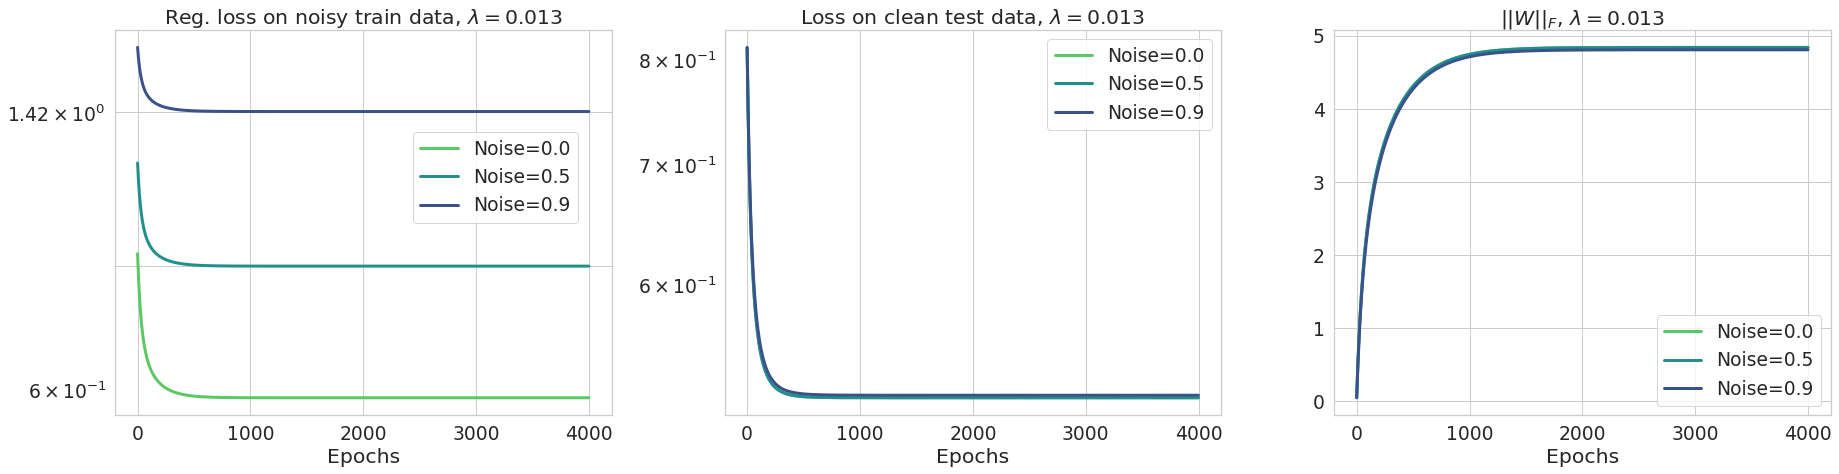

In [ ]:
sb.set(style='ticks',font_scale=1.7)
sb.set_theme(style='whitegrid', font_scale=1.7)

noise_frac = [0.0, 0.5, 0.9]
c_r = 0.013

with sb.color_palette('viridis_r', 3):
  fig, axs = plt.subplots(1, 3, figsize=(26, 7))
  for i in range(3):
    axs[0].plot(train_losses[i], label=f'Noise={noise_frac[i]}', linewidth=3)
  axs[0].title.set_text(f'Reg. loss on noisy train data, $\lambda=${c_r}')
  axs[0].legend(loc=(0.6, 0.5))
  axs[0].set_xlabel('Epochs')
  axs[0].set_yscale('log')
  axs[0].set_yticks([round(train_losses[i][-1], 2) for i in range(1,3)])

# print([train_losses[i][-1] for i in range(3)])
with sb.color_palette('viridis_r', 3):
  for i in range(3):
    axs[1].plot(test_losses[i], label=f'Noise={noise_frac[i]}', linewidth=3)
  axs[1].title.set_text(f'Loss on clean test data, $\lambda=${c_r}')
  axs[1].legend()
  axs[1].set_xlabel('Epochs')
  axs[1].set_yscale('log')

with sb.color_palette('viridis_r', 3):
  for i in range(3):
    axs[2].plot(W_evolutions[i], label=f"Noise={noise_frac[i]}", linewidth=3)
  axs[2].title.set_text(f"$||W||_F$, $\lambda=${c_r}")
  axs[2].legend()
  axs[2].set_xlabel('Epochs')

plt.tight_layout()

 ***NOTE : T specifies the number of passes through the data NOT the number of S.G.D. updates ***

#OLD

m is  5
0.5431816003826908
0.3101189269717772
0.3085799375391016
0.30857295516725586
0.30856750301487873
nn_overparam_5.pdf


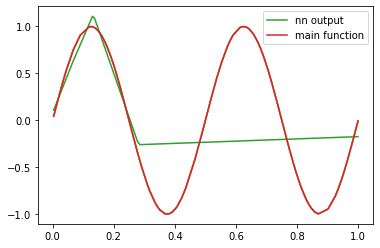

In [ ]:
run_experiment(m=5, T=50000) # runing experiment using 5 hidden units

m is  10
0.5611405904516173
0.3329874249778322
0.3166942349095455
0.310764747497162
0.31031670138616596
nn_overparam_10.pdf


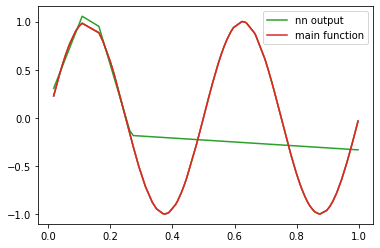

In [ ]:
run_experiment(m=10,T=50000) # runing experiment using 10 hidden units

m is  30
0.5208485057033756
0.0956526437815566
0.06398193799542545
0.04012967242293222
0.0472073670827427
0.05014507129412567
0.050015114227022706
0.04922298015262401
0.04836136190975207
0.04745909066921328
nn_overparam_30.pdf


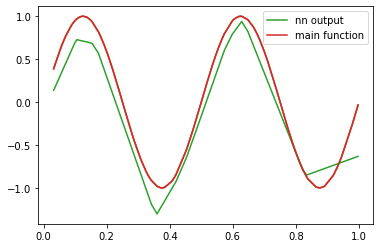

In [ ]:
run_experiment(m=30,T=100000) # runing experiment using 30 hidden units

In [ ]:
# def piecewise_linear_data(n):
#     # returns n samples (x,y) of a piecewise linear function

#     x = 12 * np.random.rand(n)
#     x = np.asarray(sorted(x))
#     y = np.zeros(n)

#     idx_1 = x<3
#     idx_2 = np.logical_and(x>3, x<6)
#     idx_3 = np.logical_and(x>6, x<9)
#     idx_4 = x>9

#     y[idx_1] = x[idx_1]
#     y[idx_2] = -x[idx_2] + 6
#     y[idx_3] = x[idx_3] - 6
#     y[idx_4] = -x[idx_4] + 12

#     return x, y